# Setup: import data

In [1]:
import pandas as pd

df = pd.read_parquet('posts.parquet')
print(f'Loaded {len(df)} posts')
df.head(n=10)

# Columns in this dataframe:
# 
#     id:        Reddit post ID on reddit. The post itself can be viewed at
#                https://reddit.com/r/pokemontrades/comments/{id}
#     title:     Post title.
#     body:      Post body (in Markdown format).
#     submitter: The username of the submitter
#     time:      Post submission time, in UTC
#     flair:     Post flair (at the time the post was scraped)
#     hit:       Whether ApriBot's crude detection mechanism (keyword-search) thought the post was Aprimon-related.
#     vote:      /r/BankBallExchange's judgment as to whether the post was Aprimon-related. This is the ground truth.

Loaded 5792 posts


,id,title,body,submitter,time,flair,hit,vote
0,13gxmuw,LF: Drilbur and Solosis FT: Ask,Hello! Im currently in the process of breeding...,Dracon715,2023-05-14 00:35:25,SMUSUM,True,False
1,13gx0eg,"LF: 6IV Non-English Ditto FT: Apriballs, Abili...",I’ve got pretty much everything aside from ✨ m...,MistaKleen,2023-05-14 00:07:42,SV,True,False
2,13gwnha,"LF H-Zoroark and Flabebe Codes, Jiseok Lee Gar...",Also open to other event offers!\n\n\_\_\_\_\_...,ShaikhAndBake,2023-05-13 23:51:47,Event,False,False
3,13gw0vt,"LF: Apriball Stonjourner, Yamask, Honedge, HA ...","Hi! I'm looking for a Stonjourner, Yamask, Hon...",Rainy_Days1115,2023-05-13 23:24:22,SWSH,True,True
4,13gw04b,LF: Sobble. FT: scarlet exclusives/raid exclusive,"It's the only raid exclusive that I'm missing,...",gertygaming,2023-05-13 23:23:23,SV (Closed),False,False
5,13gvv1y,LF: Apriball Chespin FT: Other Apriball Chespin,Still need Chespin in the following balls (HA ...,RevolutioFalco,2023-05-13 23:17:05,SV,True,True
6,13gvr1f,"LF Moon Ball Hisuian Zorua, Heavy Ball Rookide...",Breedjects acceptable for all!\n\nEdit: Just r...,foozeld,2023-05-13 23:12:12,SV,True,True
7,13gux1l,LF: Low level Oshawott and Rowlett for PLA pla...,,clee8017,2023-05-13 22:36:33,PLA,True,False
8,13guog4,LF: cyndaquil FT: froakie??,i missed typhlosian and really want a cyndaqui...,uglycynda,2023-05-13 22:26:37,SV (Closed),False,False
9,13gucgy,"[SV] FT: Aprishinies, Shinies LF: Apriballs","FT (all shinies, all untouched):\n\n|Pokemon|B...",Only_Television2030,2023-05-13 22:13:07,Shiny,True,False


# How accurate was the original detection mechanism?

To visualise this, we can plot what's known as a *confusion matrix*, where each row corresponds to what the post *should* have been identified as, and each column corresponds to what the post was actually classified as.

The top-left and bottom-right entries, where the predicted and actual classes match each other, are the cases where the prediction was successful.

The bottom-left entry contains *false negatives*: posts which really were about Aprimon but weren't picked up on. It's reassuring that there aren't many of these!

The top-right entry contains *false positives*: posts which didn't really have Aprimon, but were still picked up. There are lots of these! This isn't really surprising, because I designed the keyword search to be very permissive, the rationale being that we'd rather get extra notifications about unwanted posts than miss out on posts we were genuinely interested in.

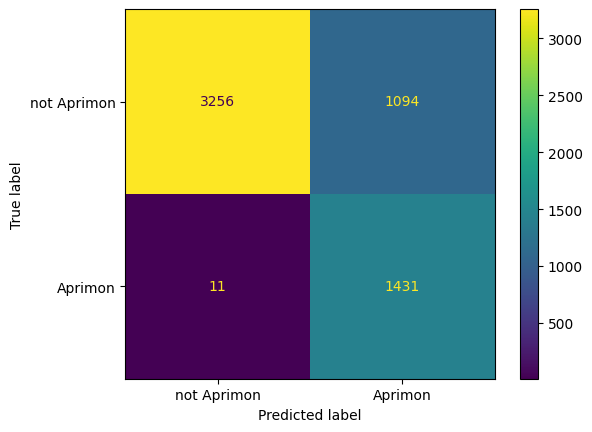

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=df.vote, y_pred=df.hit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not Aprimon', 'Aprimon'])
disp.plot()
plt.show()

We can extract some metrics from this:

 - *Accuracy*: the proportion of posts that were overall correctly categorised
 - *Sensitivity*: the proportion of Aprimon posts that were correctly picked up
 - *Specificity*: the proportion of non-Aprimon posts that were correctly ignored (we expect this to be not amazing)

In [3]:
def get_metrics(y_true, y_pred):
    "returns accuracy, sensitivity, and specificity (in that order)."
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    true_pos = cm[1, 1]
    true_neg = cm[0, 0]
    false_pos = cm[0, 1]
    false_neg = cm[1, 0]
    return ((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),
            true_pos / (true_pos + false_neg),
            true_neg / (true_neg + false_pos))

accuracy, sensitivity, specificity = get_metrics(y_true=df.vote, y_pred=df.hit)
print(f'accuracy:    {accuracy:.2%}')
print(f'sensitivity: {sensitivity:.2%}')
print(f'specificity: {specificity:.2%}')

accuracy:    80.92%
sensitivity: 99.24%
specificity: 74.85%


# Text vectorisation

Most machine learning algorithms use vectors as inputs; we thus first need to (somehow) convert our input data into vectors.
We'll only use the post title and post body as our inputs.
These are both text-based, and can have variable lengths.

In this notebook, we'll look at several ways of converting these into vectors.
The first of these will be the 'bag of words' model, where we generate a *vocabulary* which is a list of all words found across all posts.
The size of the vocabulary will be the number of features $n$, and each post will be converted into a vector of length $n$, where
the $i$-th component of the vector is 1 if the $i$-th word is present in the text, and 0 if it is not.

But first, we'll clean up the text by removing things like punctuation and capitalisation.

In [4]:
import re

def to_words(text):
    # remove Markdown links
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # split on spaces
    words = text.split()
    # remove links (heuristically)
    words = [w for w in words if not w.startswith('http') and not w.startswith('www')]
    # convert curly double/single quotes to plain single quotes
    words = [w.replace('“', "'").replace('”', "'").replace('‘', "'").replace('’', "'") for w in words]
    # split on other punctuation (except apostrophes and hyphens) and convert to lowercase
    words = [w for word in words for w in re.split(r"[^A-Za-z0-9'-]+", word.lower())]
    # remove apostrophes and hyphens at either end
    words = [re.sub(r"^['-]+|['-]+$", '', w) for w in words]
    # get rid of anything that doesn't have at least one letter
    return [s for s in words if any(c.isalpha() for c in s)]
    
example_words = to_words(df.iloc[1].body)

# same as printing example_words directly, but split over lines
for i in range(0, len(example_words), 10):
    print(', '.join("'" + s + "'" for s in example_words[i:i + 10]))

'i've', 'got', 'pretty', 'much', 'everything', 'aside', 'from', 'mons', 'just', 'ask'
'if', 'you', 'need', 'something', 'in', 'particular', 'and', 'i'll', 'let', 'you'
'know', 'if', 'i', 'have', 'it'


In [5]:
df_processed = (df.assign(body_words=df.body.apply(to_words))
                  .assign(title_words=df.title.apply(to_words))
                  .assign(all_words=lambda df: df.body_words + df.title_words)
                  .loc[:, ['id', 'body_words', 'title_words', 'all_words', 'vote']])
df_processed.head()

,id,body_words,title_words,all_words,vote
0,13gxmuw,"[hello, im, currently, in, the, process, of, b...","[lf, drilbur, and, solosis, ft, ask]","[hello, im, currently, in, the, process, of, b...",False
1,13gx0eg,"[i've, got, pretty, much, everything, aside, f...","[lf, 6iv, non-english, ditto, ft, apriballs, a...","[i've, got, pretty, much, everything, aside, f...",False
2,13gwnha,"[also, open, to, other, event, offers, gen, sh...","[lf, h-zoroark, and, flabebe, codes, jiseok, l...","[also, open, to, other, event, offers, gen, sh...",False
3,13gw0vt,"[hi, i'm, looking, for, a, stonjourner, yamask...","[lf, apriball, stonjourner, yamask, honedge, h...","[hi, i'm, looking, for, a, stonjourner, yamask...",True
4,13gw04b,"[it's, the, only, raid, exclusive, that, i'm, ...","[lf, sobble, ft, scarlet, exclusives, raid, ex...","[it's, the, only, raid, exclusive, that, i'm, ...",False


From this, we can obtain the set of all words which appear in either the body or the post.

We can use Python's set data structure to elegantly get rid of duplicates.
However, because sets are [not ordered](https://docs.python.org/3/tutorial/datastructures.html#sets), we shall then convert them into dictionaries (and sort for good measure).

In [6]:
import numpy as np

body_vocabulary_set = {word for text in df_processed.body_words for word in text}
title_vocabulary_set = {word for text in df_processed.title_words for word in text}
vocabulary_set = body_vocabulary_set | title_vocabulary_set

body_vocabulary = dict(zip(sorted(list(body_vocabulary_set)), range(len(body_vocabulary_set))))
title_vocabulary = dict(zip(sorted(list(title_vocabulary_set)), range(len(title_vocabulary_set))))
vocabulary = dict(zip(sorted(list(vocabulary_set)), range(len(vocabulary_set))))

print(f'Body vocabulary size: {len(body_vocabulary)}')
print(f'Title vocabulary size: {len(title_vocabulary)}')
print(f'Overall vocabulary size: {len(vocabulary)}')

import random
random.seed(a=1815)    # Year of publication of Jane Austen's "Emma" --- my favourite book.
print(f'Example words: {random.sample(list(vocabulary.keys()), 10)}')

Body vocabulary size: 8035
Title vocabulary size: 2858
Overall vocabulary size: 8486
Example words: ['bookeeping', 'drizzile', 'flabebe', 'town', 'memelord', 'deino', 'ok-procedure-8251', 'wont', 'sparse', 'sandiles']


This means that our *post bodies* can be represented by 8035-length vectors, and *post titles* by 2858-length vectors.

Alternatively, if we just want to obtain a single representation of a post, we can just use a 8486-length vector.
However, this sacrifices some information compared to treating them separately, as we can no longer tell whether a word occurred in the body or the title.

Here are the three *design matrices* we can obtain with these representations.
Each row in the design matrix corresponds to one observation, and each column corresponds to one feature.
Thus, if we have $m$ posts and $n$ features, the design matrix should have the shape $(m \times n)$.

We'll first try to read the design matrices from files that we've saved on a previous notebook run.
If these don't exist, then we can regenerate them from the dataframes above, which takes a few minutes.

In [7]:
def get_feature_vector(words: list[str], vocab: np.ndarray):
    feat = np.zeros(len(vocab))
    for word in words:
        try:
            feat[vocab[word]] = 1
        except KeyError:
            pass
    return feat
    
from pathlib import Path

def make_design_matrix(words_series, vocab):
    return np.array([get_feature_vector(words, vocab) for words in words_series])
        
X_body = make_design_matrix(df_processed['body_words'], body_vocabulary)
X_title = make_design_matrix(df_processed['title_words'], title_vocabulary)
X_overall = make_design_matrix(df_processed['all_words'], vocabulary)

print(X_body.shape)
print(X_title.shape)
print(X_overall.shape)

(5792, 8035)
(5792, 2858)
(5792, 8486)


We should also generate a vector of targets:

In [8]:
T = df_processed.vote.to_numpy()
T.shape

(5792,)

We've done all of this by hand so far.

In fact, `scikit-learn` provides functions which do almost exactly the same thing as what we've done above, except that the default tokenisation process (i.e. converting the text into individual words, or tokens) is somewhat different.
As it turns out, the biggest differences are to do with apostrophes and hyphens—which we've specifically retained.
For example, `scikit-learn` splits 'on-hand' into 'on' and 'hand'.
It also deletes words that are one character long, such as 'I' and 'a'.
Quoting from [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

> The default regexp select *(sic)* tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary.keys())
# Note that here, we're feeding scikit-learn a nicely sanitised string that is
# obtained by joining our own tokens together. If we were to directly feed it
# the Markdown text, it would probably churn out a bunch of rubbish.
X_overall_sklearn = vectorizer.fit_transform(df_processed.all_words.apply(lambda ws: " ".join(ws))).toarray()
X_overall_sklearn.shape

# How different are X_overall and X_overall_sklearn?
differences = (X_overall != X_overall_sklearn)
print(f'Number of differences: {differences.sum()} ({differences.sum() / X_overall.size:.2%} out of {X_overall.size} entries)')

# Which columns have the most difference?
differences_by_column = differences.sum(axis=0)
most_different_columns = np.argpartition(differences_by_column, -20)[-20:]
most_different_words = [(list(vocabulary.keys())[i], differences_by_column[i]) for i in most_different_columns]
print(f'Top differences, accounting for {sum(t[1] for t in most_different_words)} of the above: ')
for t in sorted(most_different_words, key=lambda t: t[1], reverse=True):
    print('-', t)

Number of differences: 19890 (0.04% out of 49150912 entries)
Top differences, accounting for 11254 of the above: 
- ('i', 3142)
- ('a', 2524)
- ("i'm", 1253)
- ("don't", 640)
- ('don', 640)
- ("i'll", 421)
- ("i'd", 247)
- ('self', 230)
- ("you're", 226)
- ('on-hands', 206)
- ("i've", 201)
- ('hands', 195)
- ('non', 182)
- ("it's", 179)
- ('x', 173)
- ('r', 171)
- ('on-hand', 168)
- ('on', 166)
- ('hand', 145)
- ('h', 145)


If we feed `scikit-learn` the appropriate `token_pattern` argument, though, then it turns out that we can exactly reproduce our manual featurisation:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(binary=True, vocabulary=vocabulary.keys(), token_pattern=r'\b[A-Za-z0-9][A-Za-z0-9\'-]*[A-Za-z0-9]\b|\b[A-Za-z]\b')
X_overall_sklearn2 = vectorizer2.fit_transform(df_processed.all_words.apply(lambda ws: " ".join(ws))).toarray()

# How different are X_overall and X_overall_sklearn2?
differences = (X_overall != X_overall_sklearn2)
print(f'Number of differences: {differences.sum()} ({differences.sum() / X_overall.size:.2%} out of {X_overall.size} entries)')

Number of differences: 0 (0.00% out of 49150912 entries)


# Train/test split

At this point, we split our dataset up into two portions: 80% for training, and 20% for testing.

The fact that we performed featurisation before the data were split is not a problem with the present model we are using.
It is true that the training set will contain 'features' that only exist in the test set, but the value of such features will always be zero (since they do not appear in the training set), and a feature that is always zero should not be captured by the resulting model.

In [11]:
random.seed(a=1815)
n = X_overall.shape[0]
test_indices = random.sample(range(n), n // 5)
test_indices_mask = np.zeros(n)
test_indices_mask[test_indices] = 1

X_body_train = X_body[test_indices_mask == 0]
X_body_test = X_body[test_indices_mask == 1]

X_title_train = X_title[test_indices_mask == 0]
X_title_test = X_title[test_indices_mask == 1]

X_overall_train = X_overall[test_indices_mask == 0]
X_overall_test = X_overall[test_indices_mask == 1]

T_train = T[test_indices_mask == 0]
T_test = T[test_indices_mask == 1]

We should check the distribution of positive and negative posts in our training and test set to make sure that they aren't skewed.

In [12]:
print(f'Aprimon posts in training set: {(T_train == 1).sum()}/{T_train.size} = {(T_train == 1).sum() / T_train.size:.2%}')
print(f'Aprimon posts in test set: {(T_test == 1).sum()}/{T_test.size} = {(T_test == 1).sum() / T_test.size:.2%}')

Aprimon posts in training set: 1148/4634 = 24.77%
Aprimon posts in test set: 294/1158 = 25.39%


# Naive Bayes

The first model we'll use is a *naive Bayes model*.
As the name suggests, this is based on Bayes's theorem.
Let $r = [r_1, r_2, \ldots, r_n]$ be a Reddit post containing a set of words, $R$ be the random variable that corresponds to a post, and $A$ be the event that the post is assigned as an Aprimon trade. Then:

$$P(A|R=r) = \frac{P(R=r|A) P(A)}{P(R=r)}.$$

The *naive* part means that we assume that each feature of $R$ contributes independently to whether or not it is an Aprimon post.
Mathematically, this means that

$$P(R = r) = P(R_1 = r_1)P(R_2 = r_2)\cdots P(R_n = r_n),$$

and thus

$$P(A|R = r) = \frac{P(R_1 = r_1|A)P(R_2 = r_2|A)\cdots P(R_n = r_n|A) P(A)}{P(R_1 = r_1) P(R_2 = r_2) \cdots P(R_n = r_n)}.$$

Note, here, that $R_i$ is a *random variable* which can take two values, 0 or 1.
The value which it actually takes on in a given post is denoted by $r_i$.

Traditionally, the denominator is not explicitly calculated because it is a constant.
Calculating only the numerator gives us unnormalised 'probabilities', which on their own cannot be interpreted.

However, if we calculate these unnormalised 'probabilities' for different classes and compare their magnitudes, we can directly compare these values to determine which class is the most suitable.
In our case, we only have two classes, so we need to calculate

 - $P(R_1 = r_1|A)P(R_2 = r_2|A)\cdots P(R_n = r_n|A)P(A)$
 - $P(R_1 = r_1|\bar{A})P(R_2 = r_2|\bar{A})\cdots P(R_n = r_n|\bar{A})P(\bar{A})$
 
where $\bar{A}$ is the event where the post is *not* an Aprimon trade.

Let's work with the *entire post* first, i.e., the 8486-sized vectors in `X_overall`.

To use this model, we need to calculate:

 - The value of $P(R_i = 1 | A)$ for each $i$. This is simply the proportion of Aprimon posts where the word $i$ is seen. (And we can then get $P(R_i = 0 | A) = 1 - P(R_i = 1 | A)$.)
 - $P(A)$. This is the overall proportion of Aprimon posts.
 
and the same for the non-Aprimon posts.

In [13]:
hit_indices = T_train.nonzero()[0]
miss_indices = (T_train == 0).nonzero()[0]

hits = X_overall_train[hit_indices]
misses = X_overall_train[miss_indices]

n_hits = hits.shape[0]
n_misses = misses.shape[0]

p_A = n_hits / (n_hits + n_misses)
p_notA = n_misses / (n_hits + n_misses)

p_word_given_A = hits.sum(axis=0) / n_hits
p_word_given_notA = misses.sum(axis=0) / n_misses

By the way, instead of multiplying all these probabilities together (which gives us a very, very tiny number), we will sum their logarithms instead.
This makes the process more numerically stable.

Now, we have `p_word_given_A` as a vector of length $n$ where the $i$-th element is $P(R_i = 1 | A)$.
This also means that the $i$-th element of `1 - p_word_given_A` is $P(R_1 = 0 | A)$.

The central quantity we need to calculate is the (logarithm of the) *likelihood*,

$$LL(A) = \log \left[ \prod_{i=1}^n P(R_i = r_i | A) \right] = \sum_{i=1}^n \log[P(R_i = r_i|A)]$$

If we break this sum up into the cases where $r_i = 1$ and $0$ respectively, then we can re-express this as

$$\begin{align}
LL(A) &= \sum_{r_i = 1} \log[P(r_i = 1 | A)] + \sum_{r_i = 0} \log[P(r_i = 0 | A)] \\
      &= \sum_{r_i = 1} \log[P(r_i = 1 | A)] + \sum_{r_i = 0} \log[1 - P(r_i = 1 | A)] \\
      &= \sum_{i} r_i \log[P(r_i = 1 | A)] + \sum_{i} (1 - r_i) \log[1 - P(r_i = 1 | A)]
\end{align}$$

where the term $r_i$ removes the cases where $r_i = 0$ from the first sum, and the term $(1 - r_i)$ removes the cases where $r_i = 1$ from the second.
Re-combining the sums:

$$LL(A) = \sum_{i} r_i \log[P(r_i = 1 | A)] + (1 - r_i) \log[1 - P(r_i = 1 | A)]$$

The (logarithm of the) posterior probability is the log likelihood $LL(A)$, plus the log of $P(A)$.

Finally, we perform the same analysis for $\bar{A}$.

In [14]:
def log_posterior_A(post: np.ndarray):
    return np.sum(post * np.log(p_word_given_A) + (1 - post) * np.log(1 - p_word_given_A)) + np.log(p_A)
    
def log_posterior_notA(post: np.ndarray):
    return np.sum(post * np.log(p_word_given_notA) + (1 - post) * np.log(1 - p_word_given_notA)) + np.log(p_notA)

Let's try it on a random post!

In [15]:
sample_post = X_overall_train[10]

# Let's see what words it contains
print([list(vocabulary.keys())[i] for i in sample_post.nonzero()[0]])

# What does the model predict?
print(f'log P(A | post) is proportional to: {log_posterior_A(sample_post):.2f}')
print(f'log P(not A | post) is proportional to: {log_posterior_notA(sample_post):.2f}')

['and', 'any', 'as', 'bagon', 'charmander', 'chespin', 'clauncher', 'cyndaquil', 'exclusive', 'ft', 'fuecoco', 'gengar', 'gulpin', 'lf', 'misdreavous', 'oshawhatt', 'paradox', 'scizor', 'scorbunny', 'slowking', 'sobble', 'sprigato', 'violet', 'well']
log P(A | post) is proportional to: nan
log P(not A | post) is proportional to: nan


/var/folders/17/5jmhtwzx1zs4l2krr8v78rv40000gp/T/ipykernel_38771/1578725877.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(post * np.log(p_word_given_A) + (1 - post) * np.log(1 - p_word_given_A)) + np.log(p_A)
/var/folders/17/5jmhtwzx1zs4l2krr8v78rv40000gp/T/ipykernel_38771/1578725877.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(post * np.log(p_word_given_A) + (1 - post) * np.log(1 - p_word_given_A)) + np.log(p_A)
/var/folders/17/5jmhtwzx1zs4l2krr8v78rv40000gp/T/ipykernel_38771/1578725877.py:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(post * np.log(p_word_given_notA) + (1 - post) * np.log(1 - p_word_given_notA)) + np.log(p_notA)
/var/folders/17/5jmhtwzx1zs4l2krr8v78rv40000gp/T/ipykernel_38771/1578725877.py:5: RuntimeWarning: invalid value encountered in multiply
  return np.sum(post * np.log(p_word_given_notA) + (1 - post) * np.log(1 - p_word_given_notA)) + np.log(p_notA)


Whoopsies. What happened?

The error above suggests that we tried to take the logarithm of zero, which in turn means that $P(r_i | A)$ was zero for some $i$.
This can, happen if *none* (or indeed, *all*) of the Aprimon posts we've seen contain a given word.

To fix this, we need to perform some kind of smoothing.
The most common is to 'add in' a number, $\alpha$, of 'pseudo-posts' which contain *every word* to each class.
Previously, we had that

$$P(R_i = 1 | A) = \frac{N(R_i = 1 | A)}{N(R_i = 0 | A) + N(R_i = 1 | A)},$$

where $N(R_i = 1 | A)$ is the number of Aprimon posts which contain the word $i$.
We now add $\alpha$ 'posts' which contain the word and another $\alpha$ which don't, so that instead of the above,

$$P(R_i = 1 | A) = \frac{N(R_1 = 1 | A) + \alpha}{N(R_1 = 0 | A) + N(R_1 = 1 | A) + 2\alpha}.$$

There's no stipulation on what the value of $\alpha$ should be (it doesn't have to be an integer!)
Larger values tend to smear the probabilities towards being uniform (consider the case where $\alpha \gg N$); we can view this as being a very strong prior.
Conversely, a smaller value corresponds to a weaker prior.

For now, let's try with $\alpha = 1$.

In [16]:
def get_smoothed_probabilities(alpha: float):
    p_word_given_A = (hits.sum(axis=0) + alpha) / (n_hits + 2 * alpha)
    p_word_given_notA = (misses.sum(axis=0) + alpha) / (n_misses + 2 * alpha)
    return p_word_given_A, p_word_given_notA

p_word_given_A_smoothed, p_word_given_notA_smoothed = get_smoothed_probabilities(alpha=1)

def log_posterior_A_smoothed(post: np.ndarray):
    return np.sum(post * np.log(p_word_given_A_smoothed) + (1 - post) * np.log(1 - p_word_given_A_smoothed)) + np.log(p_A)
    
def log_posterior_notA_smoothed(post: np.ndarray):
    return np.sum(post * np.log(p_word_given_notA_smoothed) + (1 - post) * np.log(1 - p_word_given_notA_smoothed)) + np.log(p_notA)

print(f'smoothed log P(A | post) is proportional to: {log_posterior_A_smoothed(sample_post):.2f}')
print(f'smoothed log P(not A | post) is proportional to: {log_posterior_notA_smoothed(sample_post):.2f}')

smoothed log P(A | post) is proportional to: -151.99
smoothed log P(not A | post) is proportional to: -128.37


Since the logarithm is a monotonically increasing function, a larger $\log(P)$ corresponds to a larger $P$, and so we want to choose the class which has the largest $\log(P)$—which in this case is *not A*.
Our model has thus assigned this post to *not* an Aprimon post, which seems sensible given its contents!

The difference between the two log-probabilities (which corresponds to a ratio of probabilities) tells us how certain our model is of its assignment.
We won't use it here, though, because these are generally really large (or really small) numbers which don't provide any kind of subtlety.
So, we'll make do with just assigning a label based on which log-probability is larger.

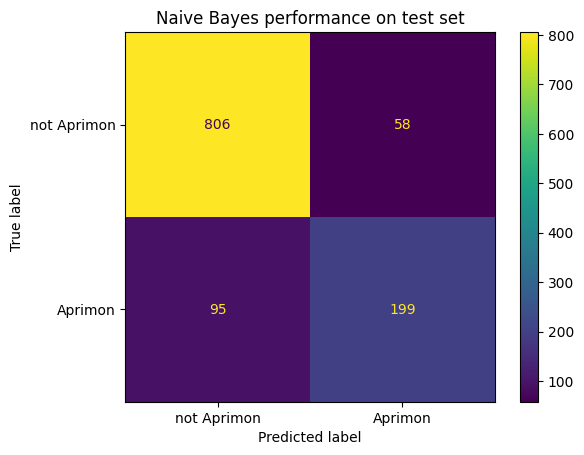

In [17]:
def assign_label(post: np.ndarray):
    return 1 if log_posterior_A_smoothed(post) > log_posterior_notA_smoothed(post) else 0

test_predictions = np.array([assign_label(post) for post in X_overall_test])

cm_naive_bayes = confusion_matrix(y_true=T_test, y_pred=test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_naive_bayes, display_labels=['not Aprimon', 'Aprimon'])
disp.plot()
plt.title("Naive Bayes performance on test set")
plt.show()

And let's calculate the same metrics as before...

In [18]:
accuracy, sensitivity, specificity = get_metrics(y_true=T_test, y_pred=test_predictions)
print(f'accuracy:    {accuracy:.2%}')
print(f'sensitivity: {sensitivity:.2%}')
print(f'specificity: {specificity:.2%}')

accuracy:    86.79%
sensitivity: 67.69%
specificity: 93.29%


This is to be compared with our original keyword-searching mechanism:

- Accuracy:    80.92%
- Sensitivity: 99.24%
- Specificity: 74.85%

So it seems that we have gotten a lot better at eliminating false-positives (specificity), with a compromise in that there are now more false-negatives (sensitivity).
Overall, accuracy has gone up: this is not very surprising, because there are more negatives than positives to begin with.
So, if we do a better job at identifying negatives but a poorer job at identifying positives, our overall accuracy should go up.

Incidentally, let's try to do this with `scikit-learn`'s functions instead, to make sure that we did everything correctly.

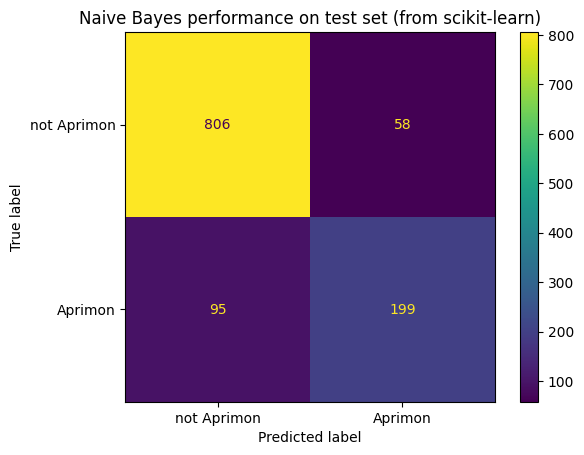

In [19]:
# We are using 'BernoulliNB' because we assume that the $R_i$'s obey the Bernoulli distribution, i.e. 0 or 1 only.
from sklearn.naive_bayes import BernoulliNB

classifier = BernoulliNB(alpha=1)
classifier.fit(X_overall_train, T_train)
sklearn_predictions = classifier.predict(X_overall_test)

cm_naive_bayes = confusion_matrix(y_true=T_test, y_pred=sklearn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_naive_bayes, display_labels=['not Aprimon', 'Aprimon'])
disp.plot()
plt.title("Naive Bayes performance on test set (from scikit-learn)")
plt.show()

Hooray! :)